### Importing Necesssary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split , StratifiedKFold  , StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import os
import random
pd.set_option("display.max_columns",30)

%matplotlib inline

#### Set Seed for Reproducable Results

In [2]:
random.seed(0)
np.random.seed(0)

#### Failsafe Data Loading in scenrios notebook is used on colab

In [3]:
try:
    train = pd.read_csv("../Train.csv" , low_memory=False)
    test = pd.read_csv("../Test.csv" , low_memory=False)
    ss = pd.read_csv("../SampleSubmission.csv" , low_memory=False)
    var_def = pd.read_csv("../VariableDefinitions.csv" , low_memory=False)
except:
    !colab_download
    train = pd.read_csv("../Train.csv" , low_memory=False)
    test = pd.read_csv("../Test.csv" , low_memory=False)
    ss = pd.read_csv("../SampleSubmission.csv" , low_memory=False)
    var_def = pd.read_csv("../VariableDefinitions.csv" , low_memory=False)

In [4]:
print(f"Train Shape {train.shape}")
print(f"Test Shape {test.shape}")
print(f"Sample_Sub Shape {ss.shape}")
print(f"Variable Definitions Shape {var_def.shape}")

Train Shape (12079, 14)
Test Shape (5177, 13)
Sample_Sub Shape (5177, 2)
Variable Definitions Shape (13, 2)


In [5]:
DROP_COLS = ["ID"]
TARGET = "target"

In [6]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [7]:
TARGET = "target"
DROP_COLS = ["ID"]

In [8]:
n_train = train.shape[0]
n_test = test.shape[0]

### Check Data Types

In [9]:
train.dtypes

ID                        object
Policy Start Date         object
Policy End Date           object
Gender                    object
Age                        int64
First Transaction Date    object
No_Pol                     int64
Car_Category              object
Subject_Car_Colour        object
Subject_Car_Make          object
LGA_Name                  object
State                     object
ProductName               object
target                     int64
dtype: object

### Describe and Info

In [10]:
train.describe()

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


### Missing Values

In [12]:
train.isna().sum() / len(train) * 100

ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     2.972100
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
Car_Category              30.946270
Subject_Car_Colour        57.637222
Subject_Car_Make          20.498386
LGA_Name                  53.613710
State                     53.713056
ProductName                0.000000
target                     0.000000
dtype: float64

In [13]:
test.isna().sum() / len(test) * 100

ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     3.013328
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
Car_Category              31.639946
Subject_Car_Colour        58.045200
Subject_Car_Make          20.494495
LGA_Name                  53.737686
State                     53.853583
ProductName                0.000000
dtype: float64

In [14]:
train.Gender.unique()

array(['Male', 'Female', 'Entity', 'Joint Gender', nan, 'NO GENDER',
       'NOT STATED', 'SEX'], dtype=object)

In [15]:
test.Gender.unique()

array(['NO GENDER', nan, 'Female', 'Male', 'Joint Gender', 'NOT STATED',
       'Entity', 'SEX'], dtype=object)

### Target Distribution

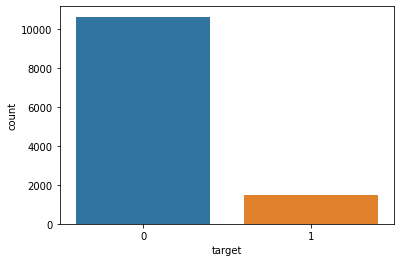

In [16]:
sns.countplot(x="target",data=train)
plt.show()

That's one huge imbalance 😑

In [18]:
train.target.value_counts() / len(train)

0    0.879543
1    0.120457
Name: target, dtype: float64

Target 0 takes 88%

Target 1 takes 12%

Hugo Class Imbalance

#### Change Datetime Features

In [19]:
#Policy Date Features
train["Policy Start Date"] = pd.to_datetime(train["Policy Start Date"])
test["Policy Start Date"] = pd.to_datetime(test["Policy Start Date"])

#Policy End Feature
train["Policy End Date"] = pd.to_datetime(train["Policy End Date"])
test["Policy End Date"] = pd.to_datetime(test["Policy End Date"])

#First Transaction Date
train["First Transaction Date"] = pd.to_datetime(train["First Transaction Date"])
test["First Transaction Date"] = pd.to_datetime(test["First Transaction Date"])

In [20]:
missing_features = [col for col in train.columns if train[col].isna().sum() > 1]
cat_features = [col for col in train.columns if train[col].dtype == "O" and col != "ID"]
num_features = [col for col in train.columns if train[col].dtype == "int" or train[col].dtype == "float"]
datetime_features = [col for col in train.columns if train[col].dtype == "datetime64[ns]"]

In [21]:
missing_features

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State']

In [22]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


### Feature Engineering 1

In [23]:
train = train.assign(policy_start_year = train["Policy Start Date"].dt.year,
            policy_start_month = train["Policy Start Date"].dt.month,
            policy_start_day = train["Policy Start Date"].dt.day,
            policy_end_year = train["Policy End Date"].dt.year,
            policy_end_month = train["Policy End Date"].dt.month,
            policy_end_day = train["Policy End Date"].dt.day,
            first_transaction_year = train["First Transaction Date"].dt.year,
            first_transaction_month = train["First Transaction Date"].dt.month,
            first_transaction_day = train["First Transaction Date"].dt.day)

In [24]:
test = test.assign(policy_start_year = test["Policy Start Date"].dt.year,
            policy_start_month = test["Policy Start Date"].dt.month,
            policy_start_day = test["Policy Start Date"].dt.day,
            policy_end_year = test["Policy End Date"].dt.year,
            policy_end_month = test["Policy End Date"].dt.month,
            policy_end_day = test["Policy End Date"].dt.day,
            first_transaction_year = test["First Transaction Date"].dt.year,
            first_transaction_month = test["First Transaction Date"].dt.month,
            first_transaction_day = test["First Transaction Date"].dt.day)

In [25]:
train["policy_duration_days"] = (train["Policy End Date"] - train["Policy Start Date"]).astype(str).str.replace(" days","")
test["policy_duration_days"] = (test["Policy End Date"] - test["Policy Start Date"]).astype(str).str.replace(" days","")

## Categorical Features

In [26]:
train[cat_features].nunique()

Gender                  7
Car_Category           16
Subject_Car_Colour     45
Subject_Car_Make       74
LGA_Name              258
State                 111
ProductName             9
dtype: int64

In [27]:
# for feat in cat_features:
#     sns.countplot(x=feat , data=train)
#     plt.xticks(rotation=90)
#     plt.show()

In [28]:
# gender_map = mapper = {"Male":"M","Female":'F','Entity':'O','Joint Gender':'O',9999:'O','NO GENDER':'O','NOT STATED':'O','SEX':'O' }

In [29]:
# train["Gender"] = train["Gender"].map(gender_map)
# test["Gender"] = test["Gender"].map(gender_map)

In [30]:
train["Policy Start Date"].dt.year.unique()

array([2010, 2007, 2009, 2006, 2001, 2005, 2003, 2002])

In [31]:
train["Policy End Date"].dt.year.unique()

array([2011, 2010, 2012, 2041, 2037, 2016, 2034])

No Customer Duplicates..Good!

In [32]:
missing_cats = [col for col in missing_features if col in cat_features]
for col in missing_cats:
    train[col].fillna("Missing",inplace=True)
    test[col].fillna("Missing",inplace=True)

In [33]:
#policy_duration_days to integet
train["policy_duration_days"] = train["policy_duration_days"].astype(int)

In [34]:
for col in cat_features:
    train_unique = set(train[col].unique())
    test_unique = set(test[col].unique())
    print(f"{col}")
    print(train_unique.difference(test_unique))
    print(test_unique.difference(train_unique))
    print()

Gender
set()
set()

Car_Category
{'CAMRY CAR HIRE', 'Tipper Truck'}
set()

Subject_Car_Colour
{'D. Red', 'Red & Blue', 'Black & White', 'Dark Green', 'Champagne', 'White & Yellow', 'Light Gray', 'Light Blue', 'White & Red'}
{'Red Maroon'}

Subject_Car_Make
{'BRILLIANCE', 'REXTON', 'Lincoln', 'ABG', 'CHANGAN', 'Yamaha', 'GAC', 'Rols Royce', 'Bajaj', 'Geely', 'Raston', 'Caddillac', 'Fiat', 'ZOYTE', 'COMMANDER', 'Howo', 'Astra', 'Jincheng', 'Motorcycle', 'Ashok Leyland', 'Jaguar', 'Tata'}
{'Datsun'}

LGA_Name
{'Ajeromi-Ifelodun', 'Bekwara', 'AKUTE', 'Tai ', 'Orolu', 'Ilorin East', 'Idemili North', 'Ohaukwu', 'Garki', 'Awka North', 'Isoko North', 'Asari-Toru', 'BARIGA', 'AKOKO-EDO', 'Rogo', 'IJAIYE', 'Akoko North West', 'Eket', 'QuaAn Pan', 'kumbotso', 'EMENE', 'Bosso', 'Epe', 'Essien Udim', 'Ogba/Egbema/Ndoni', 'Okrika', 'Akuku Toru', 'Ijebu North', 'Ijora', 'Njaba', 'AREPO', 'Kajola', 'Abakaliki', 'Akwa Ibom', 'Orsu', 'OWODE', 'Obalende', 'Isoko south', 'Esan Central', 'Karu', 'Ilesha', 

Since there are values that are not in test and not present in train and vice versa, we'll concat the train and test datset and use pandas factorize to make our lives easier

### Encode Categoricals

In [35]:
df = pd.concat([train,test])

In [36]:
df

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,policy_start_year,policy_start_month,policy_start_day,policy_end_year,policy_end_month,policy_end_day,first_transaction_year,first_transaction_month,first_transaction_day,policy_duration_days
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Missing,Missing,Car Classic,0.0,2010,5,14,2011,5,13,2010,5,14,364
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Missing,Missing,Car Classic,1.0,2010,11,29,2011,11,28,2010,11,29,364
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Missing,Missing,Car Classic,0.0,2010,3,21,2011,3,20,2010,3,21,364
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Missing,Missing,Missing,Missing,Missing,CarSafe,0.0,2010,8,21,2011,8,20,2010,8,21,364
4,00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,Missing,Missing,Missing,Lagos,Lagos,Muuve,1.0,2010,8,29,2010,12,31,2010,8,29,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172,ZYXX5AF,2010-07-18,2011-07-17,Male,48,2010-07-18,1,Saloon,Missing,Honda,Missing,Missing,CarSafe,NaN,2010,7,18,2011,7,17,2010,7,18,364
5173,ZYYOZ5L,2010-12-04,2011-12-03,Missing,50,2010-12-04,1,Missing,Missing,Missing,Victoria Island,Lagos,Car Classic,NaN,2010,12,4,2011,12,3,2010,12,4,364
5174,ZZ1GTKD,2010-09-24,2011-09-23,Male,1,2010-09-24,1,Missing,Missing,Missing,Missing,Missing,CarSafe,NaN,2010,9,24,2011,9,23,2010,9,24,364
5175,ZZDXQSI,2010-07-17,2011-07-16,Female,52,2010-07-17,1,Saloon,Grey,TOYOTA,Missing,Missing,Car Classic,NaN,2010,7,17,2011,7,16,2010,7,17,364


In [37]:
for col in cat_features:
    df[col] = pd.factorize(df[col])[0]

In [38]:
DROP_COLS + datetime_features

['ID', 'Policy Start Date', 'Policy End Date', 'First Transaction Date']

In [39]:
df.drop(labels=DROP_COLS + datetime_features , axis=1,inplace=True)

In [40]:
train_new = df[:n_train]
test_new = df[n_train:]
print(train_new.shape , test_new.shape)

(12079, 20) (5177, 20)


In [41]:
test_new.drop(TARGET,axis=1,inplace=True)

/home/temmyzeus/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
X = train_new.drop(TARGET,axis=1)
y = train[TARGET]
print(X.shape,y.shape)

(12079, 19) (12079,)


## Modelling

In [43]:
from sklearn.model_selection import cross_val_score , StratifiedShuffleSplit

In [44]:
skf = StratifiedKFold(random_state=0)
sss = StratifiedShuffleSplit(n_splits=5,random_state=0)

/home/temmyzeus/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


"Woah..POlicy Duration Days" we created apperars to be in object type, let's correct that

In [45]:
X["policy_duration_days"] = X["policy_duration_days"].astype(int)
test_new["policy_duration_days"] = test_new["policy_duration_days"].astype(int)

<ipython-input-45-f4eda4f3bc25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["policy_duration_days"] = test_new["policy_duration_days"].astype(int)


In [47]:
classifiers = [RandomForestClassifier(random_state=0),
              AdaBoostClassifier(random_state=0),
              GradientBoostingClassifier(random_state=0),
              XGBClassifier(random_state=0),
              XGBRFClassifier(random_state=0),
              CatBoostClassifier(random_state=0),
              LGBMClassifier(random_state=0),
              LogisticRegression(random_state=0),
              DecisionTreeClassifier(random_state=0)]

df = pd.DataFrame(columns=[1,2,3,4,5,"Mean","Std"] , index=[model.__class__.__name__ for model in classifiers])
for model in classifiers:
    name = model.__class__.__name__
    scores = cross_val_score(estimator=model,X=X,y=y,scoring="f1",cv=sss,n_jobs=-1,verbose=2)
#     scores = scores * -1
    scores_mean = scores.mean()
    scores_std = scores.std()
    _ = np.array([scores_mean,scores_std])
    scores = np.concatenate([scores,_])
    df.loc[name] = scores
    
display(df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

,1,2,3,4,5,Mean,Std
RandomForestClassifier,0.230769,0.227848,0.197425,0.195918,0.172414,0.204875,0.0218528
AdaBoostClassifier,0.0784314,0.0392157,0.0636943,0.0645161,0.0251572,0.0542029,0.0192444
GradientBoostingClassifier,0.161491,0.113208,0.0897436,0.0987654,0.0858896,0.109819,0.0274928
XGBClassifier,0.263636,0.256637,0.248848,0.207792,0.193548,0.234092,0.0280512
XGBRFClassifier,0.15,0.101911,0.0779221,0.100629,0.075,0.101092,0.026872
CatBoostClassifier,0.210526,0.236559,0.212291,0.168421,0.134715,0.192502,0.0362677
LGBMClassifier,0.225641,0.225806,0.179775,0.198953,0.148936,0.195822,0.0291679
LogisticRegression,0,0,0,0,0,0,0
DecisionTreeClassifier,0.196491,0.207358,0.168919,0.208054,0.209836,0.198132,0.0153404


In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
catboost_clf = RandomForestClassifier()
scr = cross_val_score(catboost_clf,
               X=X,
               y=y,
               scoring="f1",
               cv=skf,
               n_jobs=-1)
print(scr)
print(scr.mean())

[0.18141593 0.20915033 0.18691589 0.20935412 0.18518519]
0.1944042898607677


In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
model = RandomForestClassifier()
model.fit(X,y)
y_preds = model.predict_proba(test_new)

In [52]:
pd.DataFrame({"Feature":X.columns,"Importance":model.feature_importances_}).sort_values(by="Importance",ascending=False)

,Feature,Importance
1,Age,0.130020
4,Subject_Car_Colour,0.089820
14,policy_end_day,0.084068
17,first_transaction_day,0.074504
11,policy_start_day,0.073969
6,LGA_Name,0.072883
5,Subject_Car_Make,0.060141
8,ProductName,0.055371
13,policy_end_month,0.051310
10,policy_start_month,0.049595


In [53]:
def sigmoid_kekere(y):
    if y > 0.388:
        return 1
    else:
        return 0

In [54]:
ss["target"] = y_preds[:,1]

In [55]:
ss

,ID,target
0,009D84L,0.743333
1,01DO2EQ,0.504333
2,01QM0NU,0.084167
3,024NJLZ,0.097333
4,02BYET3,0.679770
...,...,...
5172,ZYXX5AF,0.000000
5173,ZYYOZ5L,0.000000
5174,ZZ1GTKD,0.000000
5175,ZZDXQSI,0.363167


In [56]:
ss["target"] = ss["target"].astype(float)

In [57]:
ss["target"] = ss["target"].apply(sigmoid_kekere)

In [58]:
ss["target"].value_counts()

0    4419
1     758
Name: target, dtype: int64

In [59]:
ss.to_csv("my_sub_.csv",index=False)